# friendly_states

This is a Python library for writing finite state machines in a way that's easy to read and prevents mistakes with the help of standard linters and IDEs.

Here's a simple example of declaring a state machine:

In [1]:
from __future__ import annotations
from friendly_states import AttributeState


class TrafficLightMachine(AttributeState):
    is_machine = True

    class Summary:
        Green: [Yellow]
        Yellow: [Red]
        Red: [Green]


class Green(TrafficLightMachine):
    def slow_down(self) -> [Yellow]:
        print("Slowing down...")


class Yellow(TrafficLightMachine):
    def stop(self) -> [Red]:
        print("Stop.")


class Red(TrafficLightMachine):
    def go(self) -> [Green]:
        print("Go!")


TrafficLightMachine.complete()

That looks like a lot of code, but it's pretty simple:

1. `TrafficLightMachine` declares the root of a state machine.
2. There are three states, which are subclasses of the machine: `Green`, `Yellow`, and `Red`.
3. Each state declares which transitions it allows to other states using functions with a return annotation (`->`). In this case, each state has one transition to one other state. For example, `Green` can transition to `Yellow` via the `slow_down` method.
4. `TrafficLightMachine.complete()` makes the machine ready for use and checks that everything is correct. In particular it verifies that the `Summary` class inside `TrafficLightMachine` matches the actual states and transitions declared. Each line of the summary shows all the possible output states from each state.

As we'll see later, a lot of the boilerplate can be generated for you, so don't worry about the effort of writing all those classes.

To use this machine, first we need an object that can store its own state. When using this library, state can be stored however you want, but the way we've declared our machine means it expects an attribute called `state`:

In [2]:
class TrafficLight:
    def __init__(self, state):
        self.state = state

light = TrafficLight(Green)
light.state

Green

The magic happens when making transitions:

In [3]:
Green(light).slow_down()
Yellow(light).stop()
light.state

Slowing down...
Stop.


Red

Making an instance of a state class such as `Green(light)` automatically checks that `light` is actually in the `Green` state and raises an exception if it's not.
Then you can call methods just like any other class. The state will automatically be changed based on the method's return annotation.

Why is this exciting? Because it's obvious to tools which transitions are available to each state. Your IDE can autocomplete `Green(light).slo` for you, and `Green(light).stop()` will be highlighted as an error before you even run the code.

Compare this with the popular library [`transitions`](https://github.com/pytransitions/transitions). States, transitions, and callbacks are all declared using strings, so it's easy to make typos and tools can't help you. In fact you have to stop your tools from warning you about all the attributes it magically generates which you have to use. There's no easy way to see all the transitions or output states from a particular state. Callbacks can be declared far away from transitions.

By contrast, when using `friendly_states`, there are no strings or magic attributes anywhere. Code is always naturally grouped together: all the transitions specific to a state appear inside that class, and logic related to a transition is in that function where you'd expect it.

## Basic usage steps

1) Ensure that you are using Python 3.7+.

2) Install this library with `pip install friendly_states`.

3) Add the line `from __future__ import annotations` at the top of the file where you define your state machine.

4) Declare the root of your state machine like so:

In [4]:
from __future__ import annotations
from friendly_states import AttributeState
    
class MyMachine(AttributeState):
    is_machine = True
    
    class Summary:
        Waiting: [Doing, Finished]
        Doing: [Checking, Finished]
        Checking: [Finished]
        Finished: []


Declaring a summary is optional, but highly recommended. The class must be named `Summary`.
It should declare the name of every state your machine will have, 
each annotated with a list of every state that can be reached directly from that state by any transition.
   
When you call `MyMachine.complete()`, this summary will be checked, and an exception will be raised explaining the problem if it doesn't match your state classes. In particular if a class is missing the exception will contain generated source code for that class so you can spend less time writing boilerplate. Let's try it now:

In [5]:
try:
    MyMachine.complete()
except Exception as e:
    print(e)


Missing states:

class Waiting(MyMachine):
    def to_doing(self) -> [Doing]:
        pass

    def to_finished(self) -> [Finished]:
        pass


class Doing(MyMachine):
    def to_checking(self) -> [Checking]:
        pass

    def to_finished(self) -> [Finished]:
        pass


class Checking(MyMachine):
    def to_finished(self) -> [Finished]:
        pass


class Finished(MyMachine):
    pass





You can copy the code above and will have a working state machine matching the summary. It's usually not exactly what you need, but it should save you a lot of time for the next step.

5) Write a class for each state. In this case our final code will look pretty similar to the generated boilerplate above. Make sure you call `.complete()` at the end.

In [6]:
class Waiting(MyMachine):
    def start_doing(self) -> [Doing]:
        print('Starting now!')   

    def skip(self) -> [Finished]:
        pass   


class Doing(MyMachine):
    def done(self, result) -> [Checking, Finished]:
        self.obj.result = result
        if self.obj.needs_checking():
            return Checking
        else:
            return Finished


class Checking(MyMachine):
    def check(self) -> [Finished]:
        print('Looks good!')


class Finished(MyMachine):
    pass


MyMachine.complete()

State classes must inherit (directly or indirectly) from the machine class, e.g. `class Waiting(MyMachine):`. A class can have any number of transitions. `Waiting` has two separate transitions, while `Finished` has none, meaning you can't leave that state. It can also have any other methods or attributes which are not transitions, like a normal class.

A transition is any method which has a return annotation (the bit after the `->` in the function definition) which is a list. The list must have one or more states that will be the result of this transition. For example, this code:

```python
class Waiting(MyMachine):
    def start_doing(self) -> [Doing]:
```

means that `start_doing` is a transition from the state `Waiting` to the state `Doing`, and calling that method will change the state.

The transition `Doing.done` demonstrates several interesting things:

- A transition can have multiple output states. In that case the method must return one of those states to indicate which one to switch to.
- Transitions are just like normal methods and can accept whatever arguments you want.
- States have an attribute `obj` which is the object that was passed to the class when it was constructed. This lets you interact with the object whose state is changing.

6) The machine doesn't store the state itself, make a different class for that:

In [7]:
class Task:
    def __init__(self):
        self.state = Waiting
        self.result = None
    
    def needs_checking(self):
        return self.result < 5

    
task = Task()
assert task.result is None
assert task.state is Waiting

Our example machine expects to find an attribute called `state` on its objects, as we've provided here. If you have different needs, see the [TODO](#TODO) section.

To change the state of your object, you first need to know what state it's in right now. Sometimes you'll need to check, but often it'll be obvious in the context of your application. For example, if we have a queue of fresh tasks, any task we pop from that queue will be in state `Waiting`.

Construct an instance of the correct state class and pass your object:

In [8]:
Waiting(task)

Waiting(obj=<__main__.Task object at 0x1128a4390>)

If you get the current state of a task wrong, that means there's a bug in your code! 
It will throw an exception before you can even call any transitions:

In [9]:
try:
    Doing(task)
except Exception as e:
    print(e)

<__main__.Task object at 0x1128a4390> should be in state Doing but is actually in state Waiting


Once you have an instance of the correct state, call whatever methods you want on it as usual. If the method is a transition, the state will automatically be changed afterwards:

In [10]:
Waiting(task).skip()
assert task.state is Finished

If you try calling a transition that doesn't exist for a state, the library doesn't even need to do anything. You'll just get the plain Python error you always get when calling a non-existent method, and your IDE/linter will warn you in advance:

In [11]:
task = Task()
try:
    Waiting(task).done(3)
except AttributeError as e:
    print(e)

'Waiting' object has no attribute 'done'


Here are the other 2 possible paths for a task from waiting to finished:

In [12]:
task = Task()
Waiting(task).start_doing()
Doing(task).done(3)
assert task.result == 3
Checking(task).check()
assert task.state is Finished

Starting now!
Looks good!


In [13]:
task = Task()
Waiting(task).start_doing()
Doing(task).done(7)
# The result '7' doesn't need checking
assert task.state is Finished

Starting now!


## Abstract state classes

Sometimes you will have common behaviour that you need to share between state classes. In that case you can use class inheritance. Here's what you need to be aware of:

1. You can't inherit from actual state classes.
2. Transitions must live in classes that inherit (directly or indirectly) from the machine class.
3. Classes that inherit from the machine (and thus can have transitions) but do not represent actual states (and thus can be inherited from) should have `abstract = True` in their body.

Here's an example:

In [14]:
class TaskMachine2(AttributeState):
    is_machine = True
    
    class Summary:
        Waiting: [Doing, Finished]
        Doing: [Finished]
        Finished: []

            
class Unfinished(TaskMachine2):
    is_abstract = True
    
    def finish(self) -> [Finished]:
        pass

    
class Waiting(Unfinished):
    def start_doing(self) -> [Doing]:
        pass


class Doing(Unfinished):
    pass


class Finished(TaskMachine2):
    pass


TaskMachine2.complete()    

Here the `Waiting` and `Doing` states are both subclasses of `Unfinished` so they get the `finish` transition for free, and you can see the result of this in the summary.

If you have an object which is in one of these states but you're not sure which, and you'd like to call the `finish` transition, just use the `Unfinished` abstract class:

In [15]:
import random

for i in range(100):
    task = Task()
    
    # Randomly start doing about half the tasks
    if random.random() < 0.5:
        Waiting(task).start_doing()
    
    # Now the task might be either Waiting or Doing
    Unfinished(task).finish()

This will still fail if you try it on a finished task:

In [16]:
try:
    Unfinished(task).finish()
except Exception as e:
    print(e)

<__main__.Task object at 0x1128b2860> should be in state Unfinished but is actually in state Finished


## State machine metadata

Machines, states, and transitions have a bunch of attributes that you can inspect:

In [17]:
# All concrete (not abstract) states in the machine
assert TaskMachine2.states == {Doing, Finished, Waiting}

# All the transition functions available for this state
assert Waiting.transitions == {Waiting.finish, Waiting.start_doing}

# The transition functions defined directly on this class, i.e. not inherited
assert Waiting.direct_transitions == {Waiting.start_doing}

# Possible output states from this transition
assert Waiting.start_doing.output_states == {Doing}

# All possible output states from this state via any transition
assert Waiting.output_states == {Doing, Finished}

# Root of the state machine
assert Waiting.machine is TaskMachine2

# Booleans about the type of class
assert TaskMachine2.is_machine and not Waiting.is_machine
assert Waiting.is_state and not Unfinished.is_state
assert Unfinished.is_abstract and not Waiting.is_abstract

### Slugs and labels

Classes also have `slug` and `label` attributes which are mostly for use by Django but may be useful elsewhere. `slug` is for data storage and `label` is for human display.

By default, `slug` is just the class name, while `label` is the class name with spaces inserted. Both can be overridden by declaring them in the class.

In [18]:
assert Waiting.slug == "Waiting"
assert TaskMachine2.label == "Task Machine 2"

## BaseState - configuring state storage and changes

At the root of all the classes in the library is `BaseState`, which has two abstract methods `get_state` and `set_state`. Subclasses determine how the object stores state and what should happen when it changes.

For example, here is the start of `AttributeState` which we've been using as the base of our machines so far:

```python
class AttributeState(BaseState):
    attr_name = "state"

    def get_state(self):
        return getattr(self.obj, self.attr_name)
```

You can declare a different `attr_name` in your machine class to store the state in that attribute of the object.

If you're storing your state in a dict or similar object, you can instead use `MappingKeyState`, which starts like this:

```python
class MappingKeyState(BaseState):
    key_name = "state"

    def get_state(self):
        return self.obj[self.key_name]
```

It can often be useful to override `set_state` to add extra common behaviour when the state changes, e.g:

In [19]:
class PrintStateChange(AttributeState):
    def set_state(self, previous_state, new_state):
        print(f"Changing {self.obj} from {previous_state} to {new_state}")
        super().set_state(previous_state, new_state)

`set_state` is called after the transition method completes.

So overall, your class hierarchy typically looks something like this:

`BaseState <- AttributeState <- Machine <- Abstract States <- Actual states`

## Troubleshooting

If things are not working as expected, here are some things to check:

- Check the attributes `machine.states`, `state.transitions`, and `transition.output_states` to see if they look as expected.
- If you override `set_state`, remember to call `super().set_state(...)`, unless you want to prevent the state from changing or you're subclassing `BaseState` directly.
- Check that the annotation on your transition is a list, i.e. it starts and ends with `[]`. For example this will not be recognised as a transition:

```python
    def start_doing(self) -> Doing:
```

- If your transition has any decorators, make sure that the decorated function still has the original `__annotations__` attribute. This is usually done by using `functools.wraps` when implementing the decorator.
- Make sure that the object stores state the way the machine expects. Typically you'll be using `AttributeState` and you should make sure that `attr_name` ("state" by default) is correct. Note that a typical machine expects objects to have just one way of storing state - you can't use the same machine to change state stored in different attributes. To overcome this, see the recipes section.
- Check that you've inherited your classes correctly. All states need to inherit from the machine.

## Recipes

The API of `friendly_states` is intentionally minimal. Here is how you can do some more complicated things.

### Construct and draw a graph

Here is how to create a graph with the popular library `networkx`:

In [20]:
import networkx as nx
machine = MyMachine

G = nx.DiGraph()
for state in machine.states:
    for output_state in state.output_states:
        G.add_edge(state, output_state)

print(G.nodes)
print(G.edges)

[Doing, Checking, Finished, Waiting]
[(Doing, Checking), (Doing, Finished), (Checking, Finished), (Waiting, Doing), (Waiting, Finished)]


To draw the graph with `matplotlib`:

/Users/alexhall/Desktop/python/friendly_states/venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/alexhall/Desktop/python/friendly_states/venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


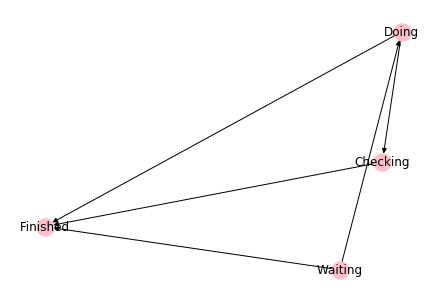

In [21]:
%matplotlib inline
nx.draw(G, with_labels=True, node_color='pink')   

To label each edge requires some more work:

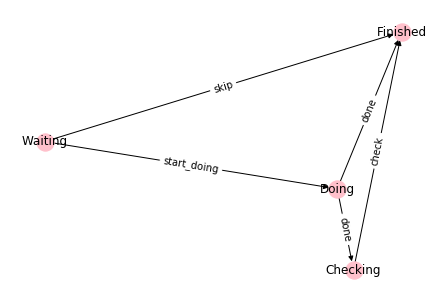

In [22]:
edge_labels = {}
G = nx.DiGraph()
for state in machine.states:
    for transition in state.transitions:
        for output_state in transition.output_states:
            edge = (state, output_state)
            G.add_edge(*edge)
            edge_labels[edge] = transition.__name__

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='pink')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels);

### Creating multiple similar machines

Suppose you want to create several machines with similar states and transitions with duplicating code. You may think you can use inheritance somehow, but that won't work, and in fact a machine can't subclass another machine. Instead you must make a function which creates the classes locally. There are many ways this could be one depending on your needs. Here's an example with identical machines except that one has an additional state:

In [24]:
from types import SimpleNamespace

def machine_factory():
    class Machine(AttributeState):
        is_machine = True

    class CommonState1(Machine):
        def to_common_state_2(self) -> [CommonState2]:
            pass

    class CommonState2(Machine):
        pass

    return SimpleNamespace(
        Machine=Machine,
        CommonState1=CommonState1,
        CommonState2=CommonState2,
    )


machine1 = machine_factory()

class DifferentState(machine1.Machine):
    def to_common_state_2(self) -> [machine1.CommonState2]:
        pass

machine1.Machine.complete()

@machine1.Machine.check_summary
class Summary:
    CommonState1: [CommonState2]
    CommonState2: []
    DifferentState: [CommonState2]


machine2 = machine_factory()
machine2.Machine.complete()

@machine2.Machine.check_summary
class Summary:
    CommonState1: [CommonState2]
    CommonState2: []

## Dynamically changing the attribute name

A typical `AttributeState` machine can only work with one attribute name. You may need to use the same machine with different object classes that use different attributes. One way is to follow a similar pattern to above with a configurable attribute name:

```python
def machine_factory(name):
    class Machine(AttributeState):
        is_machine = True
        attr_name = name

    ...
```

Another option, which may be useful for more complicated situations, is to subclass `AttributeState` to accept the attribute name on construction:

In [30]:
class DynamicAttributeState(AttributeState):
    def __init__(self, obj, attr_name):
        # override the class attribute
        self.attr_name = attr_name
        
        # must call super *after* because it checks the state
        # in the attribute with the given name
        super().__init__(obj)

class Machine(DynamicAttributeState):
    is_machine = True

class Start(Machine):
    def to_end(self) -> [End]:
        pass

class End(Machine):
    pass

Machine.complete()

thing = SimpleNamespace(state=Start, other_state=Start)

assert thing.state is Start
assert thing.other_state is Start

Start(thing, "state").to_end()
assert thing.state is End
assert thing.other_state is Start

Start(thing, "other_state").to_end()
assert thing.state is End
assert thing.other_state is End


### On enter/exit state callbacks

Whenever you want to execute some generic logic on every state transition, you should override `set_state`. But if you put all your code in there it may get long and confusing. If you want to group this logic into your state classes whenever a transition enters or exits that state, here's a mixin that you can apply to any machine:

In [39]:
class OnEnterExitMixin:
    def set_state(self, previous_state, new_state):
        previous_state(self.obj).on_exit(new_state)
        super().set_state(previous_state, new_state)
        new_state(self.obj).on_enter(previous_state)

    def on_exit(self, new_state):
        pass

    def on_enter(self, previous_state):
        pass

Then use it as follows:

In [40]:
class Machine(OnEnterExitMixin, AttributeState):
    is_machine = True

class Start(Machine):
    def end(self) -> [End]:
        pass

class End(Machine):
    def on_enter(self, previous_state):
        print(f"Ending from {previous_state}")

Machine.complete()

thing = SimpleNamespace(state=Start)
Start(thing).end()

Ending from Start
